In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#### Disable auto scrolling of output

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Global Settings

In [3]:
# Set low mass limits for clouds
lowLim512  = 8.  # Still tbd
lowLim1024 = 4.  # Still tbd
lowLim2048 = 1.

# Choose which columns we're interested in, i.e. which 'features' we want to investigate
pairPlotColumns = ['volume',  'mass', 'rPosition', 'zPositionAbs', 'polarAngle', 'vMag', 'time']

# Import and setup Dataframes

In [4]:
# Load the datasets and print headers
catalog512 = np.load('../data/physCatalog512.npy')
catalog1024 = np.load('../data/physCatalog1024.npy')
catalog2048 = np.load('../data/physCatalog2048.npy')

In [5]:
# Convert to dataframes with mass, volume, radial distance, and magnitude of velocity

# ==============================================================================
def converter(catalog, lowLim):
    # Copy data to the dataFrame
    outputDF = pd.DataFrame()
    
    outputDF['ID']         = catalog['ID']
    outputDF['volume']     = catalog['volume']
    outputDF['mass']       = catalog['mass']
    outputDF['rPosition']  = np.sqrt(catalog['positionX']**2 
                                     + catalog['positionY']**2 
                                     + catalog['positionZ']**2)
    outputDF['zPosition']    = catalog['positionZ'].reshape(-1, 1)
    outputDF['zPositionAbs'] = np.abs(outputDF['zPosition'])
    outputDF['vMag']         = np.sqrt(catalog['velocityX']**2 
                                     + catalog['velocityY']**2 
                                     + catalog['velocityZ']**2)
    outputDF['polarAngle'] = np.arccos(np.abs(outputDF['zPosition'])/outputDF['rPosition'])
    outputDF['resolution'] = catalog['resolution']
    outputDF['time']       = catalog['time']
    
    # Cut out the low mass clouds that are poorly sampled
    catalog = catalog[catalog['mass'] > lowLim]

    return outputDF
# ==============================================================================

processed512  = converter(catalog512,  lowLim512)
processed1024 = converter(catalog1024, lowLim1024)
processed2048 = converter(catalog2048, lowLim2048)

# Start Plotting 

## Different plot styles

### Scatter/Histogram

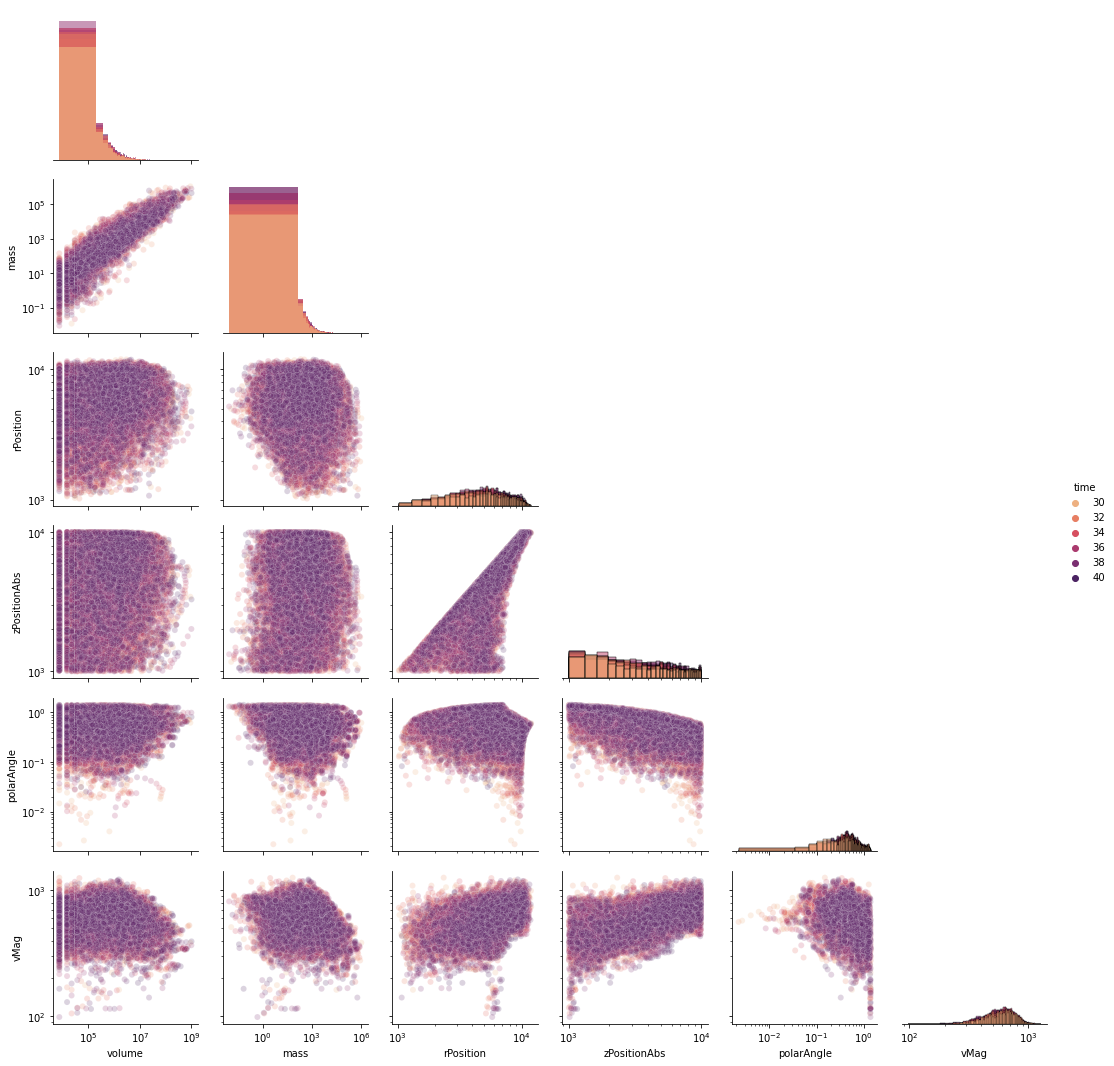

In [6]:
# Setup the plot and return the plot object
figGrid = sns.pairplot(processed512[pairPlotColumns],
                       kind      = 'scatter',
                       diag_kind = 'hist',
                       corner    = True,
                       hue       = 'time',
                       palette   = 'flare',
                       plot_kws  ={'alpha': 0.2})

# Set all axis to log log scale
a,b = figGrid.axes.shape
for i in range(a):
    for j in range(b):
        try:
            figGrid.axes[i,j].set_xscale('log')
            figGrid.axes[i,j].set_yscale('log')
        except AttributeError:
            pass

plt.show()

### KDE/KDE

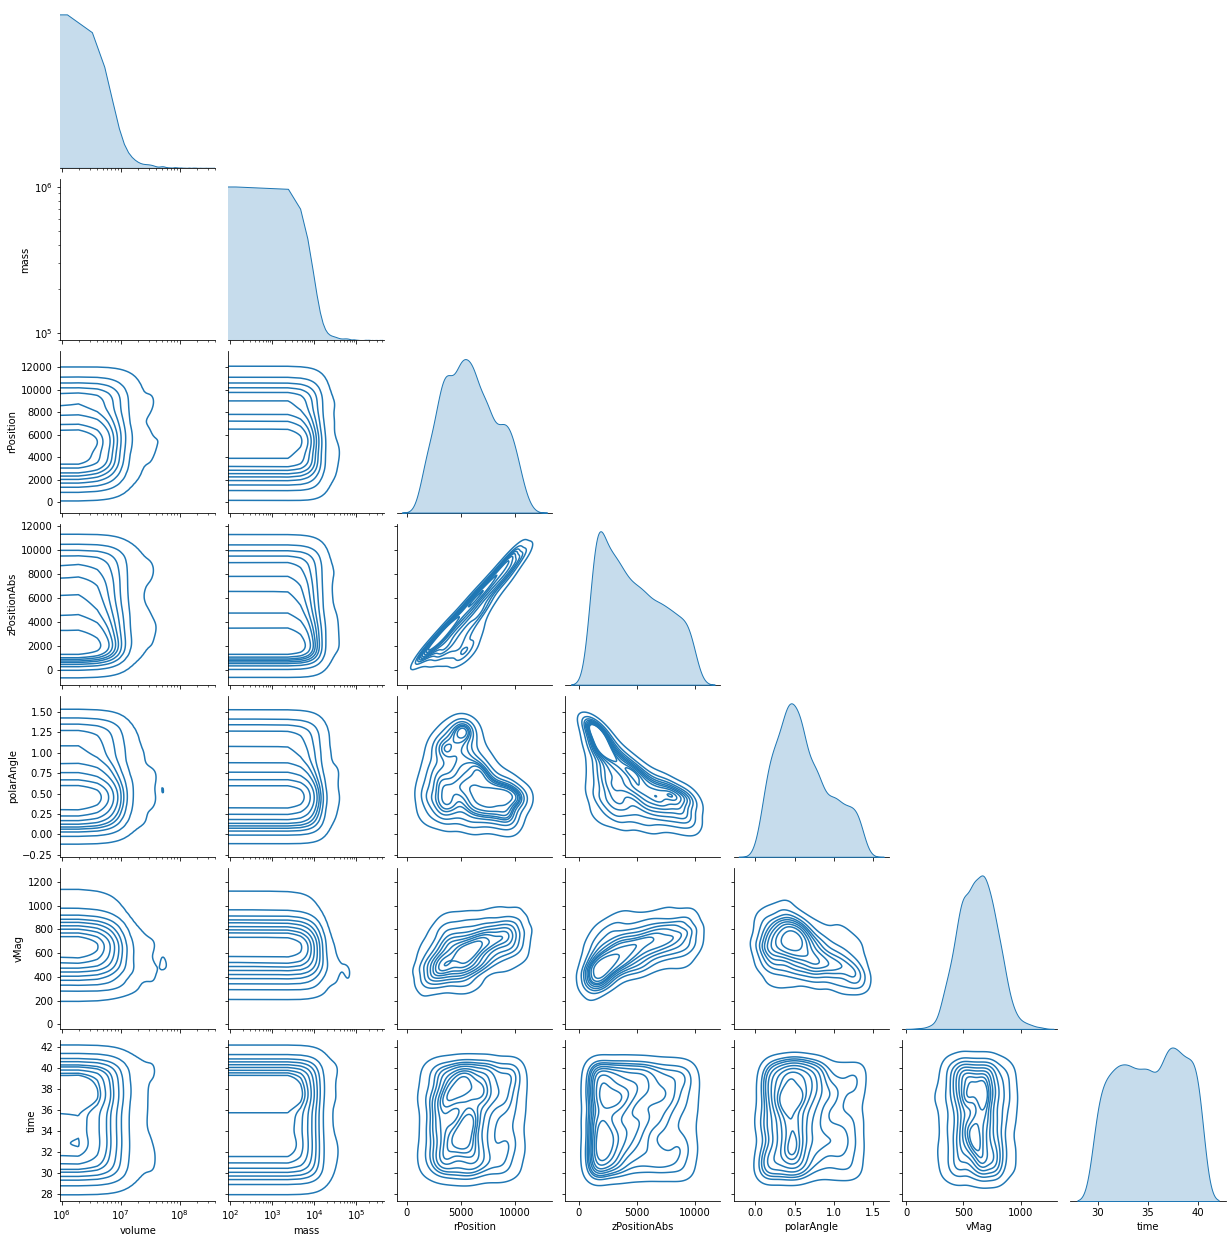

In [8]:
# Setup the plot and return the plot object
figGrid = sns.pairplot(processed512[pairPlotColumns].sample(2000),
                       kind      = 'kde',
                       corner    = True)#,
#                        diag_kind = 'kde',
#                        hue       = 'time',
#                        palette   = 'flare',
#                        plot_kws  ={'alpha': 0.2})

#                        kind      = ,
#                        diag_kind = ,

# Set all axis to log log scale
for i in range(2):
    for j in range(2):
        try:
            figGrid.axes[i,j].set_xscale('log')
            figGrid.axes[i,j].set_yscale('log')
        except AttributeError:
            pass

plt.show()

### Univariate Histogram/Histogram

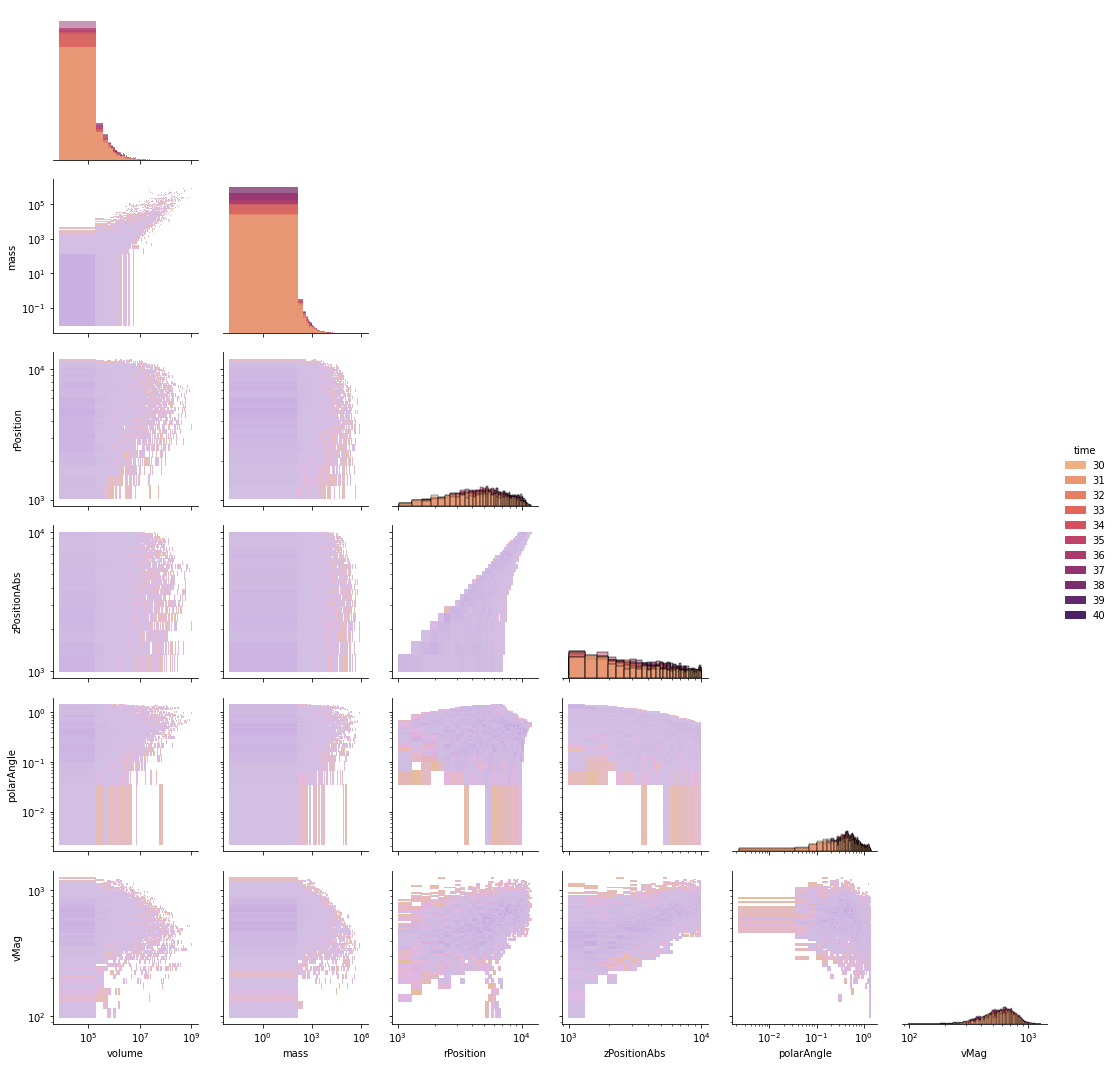

In [9]:
# Setup the plot and return the plot object
figGrid = sns.pairplot(processed512[pairPlotColumns],
                       kind      = 'hist',
                       diag_kind = 'hist',
                       corner    = True,
                       hue       = 'time',
                       palette   = 'flare')

#                        kind      = ,
#                        diag_kind = ,

# Set all axis to log log scale
a,b = figGrid.axes.shape
for i in range(a):
    for j in range(b):
        try:
            figGrid.axes[i,j].set_xscale('log')
            figGrid.axes[i,j].set_yscale('log')
        except AttributeError:
            pass

plt.show()